In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import os
from pytorch_adapt.layers import MMDLoss
from copy import deepcopy
from itertools import cycle
import torch.nn.functional as F
import random
from dalib.modules.domain_discriminator import DomainDiscriminator
from sklearn.manifold import TSNE
from collections import defaultdict

In [9]:
domains = ["Art", "Clip Art", "Real World"]

NUM_CLASSES = 65
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [10]:
d_t = "Art"
d_s = "Real World"

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [11]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

source_folder = os.path.join("officehome", d_s)
target_folder = os.path.join("officehome", d_t)

train_dataset = torchvision.datasets.ImageFolder(source_folder, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(target_folder, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

len(train_loader), len(test_loader)

(137, 76)

In [12]:
class Discriminator(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        return self.net(x)

class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None


class GradientReversal(torch.nn.Module):
    def __init__(self, lambda_=1.0):
        super().__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)


In [13]:
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output
    return hook

def infinite_loader(loader):
    while True:
        for batch in loader:
            yield batch

def train_loop(source, target, model, discriminator, sup_loss, discriminator_loss, model_optimizer, discriminator_optimizer, device, lambda_=0.2):

    model.to(device)
    model.train()
    losses, disc_losses, accuracies = [], [], []

    hook = model.avgpool.register_forward_hook(get_features('avgpool'))
    target = infinite_loader(target)
    for (x_s, y_s) in tqdm(source):
        x_t, _ = next(target)
        x_s, y_s = x_s.to(device), y_s.to(device)
        x_t = x_t.to(device)

        # --- Step 1: Train Discriminator ---
        with torch.no_grad():
            _ = model(x_s)
            source_features = features['avgpool'].view(features['avgpool'].size(0), -1)
            _ = model(x_t)
            target_features = features['avgpool'].view(features['avgpool'].size(0), -1)

        out_s = discriminator(source_features.detach())
        out_t = discriminator(target_features.detach())
        d_loss_s = discriminator_loss(out_s, torch.ones_like(out_s))
        d_loss_t = discriminator_loss(out_t, torch.zeros_like(out_t))
        d_loss = 0.5 * (d_loss_s + d_loss_t)

        discriminator_optimizer.zero_grad()
        d_loss.backward()
        discriminator_optimizer.step()

        # --- Step 2: Train Main Model ---
        pred = model(x_s)
        _ = model(x_t)
        source_features = features['avgpool'].view(features['avgpool'].size(0), -1)
        target_features = features['avgpool'].view(features['avgpool'].size(0), -1)

        out_s = discriminator(GradientReversal(lambda_)(source_features))
        out_t = discriminator(GradientReversal(lambda_)(target_features))
        adv_loss = 0.5 * (discriminator_loss(out_s, torch.zeros_like(out_s)) +
                          discriminator_loss(out_t, torch.ones_like(out_t)))

        cls_loss = sup_loss(pred, y_s)
        total_loss = cls_loss + lambda_ * adv_loss

        model_optimizer.zero_grad()
        total_loss.backward()
        model_optimizer.step()

        acc = (pred.argmax(1) == y_s).float().mean().item()
        losses.append(total_loss.item())
        disc_losses.append(d_loss.item())
        accuracies.append(acc)

    hook.remove()
    return np.mean(losses), np.mean(accuracies), np.mean(disc_losses)


def evaluate(dataloader, model, loss_fn, device):
    model.to(device)
    model.eval()
    losses = []
    accuracies = []
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss = loss_fn(pred, y)

            losses.append(loss.item())
            accuracies.append((pred.argmax(1) == y).float().mean().item())
    return np.mean(losses), np.mean(accuracies)

# DANN (Domain Adversarial Neural Network)

In [7]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

model_optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
sup_loss = nn.CrossEntropyLoss()
model = model.to(device)

discriminator = Discriminator(model.fc.in_features).to(device)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)
discriminator_loss = nn.BCEWithLogitsLoss()

In [8]:
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

for i in range(NUM_EPOCHS):
    train_loss, train_acc, disc_loss = train_loop(train_loader, test_loader, model, discriminator, sup_loss, discriminator_loss, model_optimizer, discriminator_optimizer, device)
    test_loss, test_acc = evaluate(test_loader, model, sup_loss, device)
    print(f"Epoch {i+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Discriminator Loss: {disc_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

100%|██████████| 76/76 [00:22<00:00,  3.34it/s]


Epoch 1/10, Train Loss: 3.8641, Discriminator Loss: 0.7090, Train Acc: 0.1137, Test Loss: 4.1211, Test Acc: 0.0942


100%|██████████| 76/76 [00:22<00:00,  3.35it/s]


Epoch 2/10, Train Loss: 3.0140, Discriminator Loss: 0.6787, Train Acc: 0.2586, Test Loss: 3.9120, Test Acc: 0.1528


100%|██████████| 76/76 [00:22<00:00,  3.32it/s]


Epoch 3/10, Train Loss: 2.5248, Discriminator Loss: 0.6526, Train Acc: 0.3611, Test Loss: 3.9070, Test Acc: 0.1803


100%|██████████| 76/76 [00:23<00:00,  3.19it/s]


Epoch 4/10, Train Loss: 2.1542, Discriminator Loss: 0.6282, Train Acc: 0.4478, Test Loss: 3.7828, Test Acc: 0.1937


100%|██████████| 76/76 [00:22<00:00,  3.34it/s]


Epoch 5/10, Train Loss: 1.8282, Discriminator Loss: 0.6112, Train Acc: 0.5267, Test Loss: 3.6739, Test Acc: 0.2308


100%|██████████| 76/76 [00:22<00:00,  3.38it/s]


Epoch 6/10, Train Loss: 1.5456, Discriminator Loss: 0.5984, Train Acc: 0.5910, Test Loss: 3.9247, Test Acc: 0.2179


100%|██████████| 76/76 [00:22<00:00,  3.41it/s]


Epoch 7/10, Train Loss: 1.3070, Discriminator Loss: 0.5973, Train Acc: 0.6521, Test Loss: 4.3986, Test Acc: 0.2373


100%|██████████| 76/76 [00:22<00:00,  3.33it/s]


Epoch 8/10, Train Loss: 1.0290, Discriminator Loss: 0.5849, Train Acc: 0.7412, Test Loss: 4.8377, Test Acc: 0.2317


100%|██████████| 76/76 [00:22<00:00,  3.41it/s]


Epoch 9/10, Train Loss: 0.9092, Discriminator Loss: 0.5856, Train Acc: 0.7590, Test Loss: 4.3913, Test Acc: 0.2528


100%|██████████| 76/76 [00:23<00:00,  3.28it/s]

Epoch 10/10, Train Loss: 0.7255, Discriminator Loss: 0.5747, Train Acc: 0.8227, Test Loss: 4.9388, Test Acc: 0.2275


In [ ]:
torch.save(model.state_dict(), f"resnet50_dann.pth")

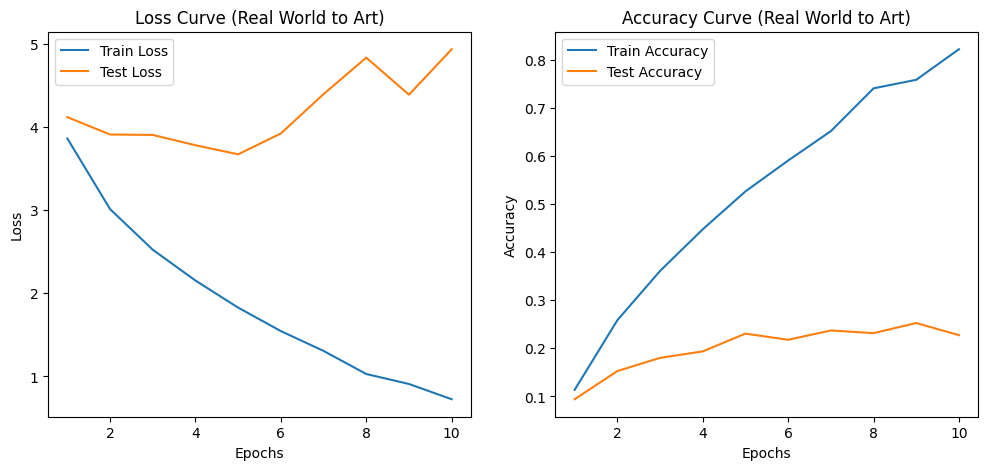

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Curve ({d_s} to {d_t})')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Accuracy Curve ({d_s} to {d_t})')
plt.legend()
plt.show()

# Concept Shift

In [14]:
def simulate_concept_shift(source_dataset, target_dataset, rare_fraction=0.2, removed_classes=5):
    np.random.seed(42)
    random.seed(42)

    # Unique class indices
    classes = list(range(len(source_dataset.classes)))

    # Pick random classes to remove from target (simulate label shift)
    removed = random.sample(classes, removed_classes)
    print(f"Removed classes from target: {removed}")

    # Rare class (under-represented)
    rare_class = random.choice([c for c in classes if c not in removed])
    print(f"Rare class in target: {rare_class}")

    # --- Filter target indices ---
    target_indices = []
    for i, (_, label) in enumerate(target_dataset):
        if label not in removed:
            if label == rare_class:
                # Keep only a small fraction of rare class
                if np.random.rand() < rare_fraction:
                    target_indices.append(i)
            else:
                target_indices.append(i)

    shifted_target = torch.utils.data.Subset(target_dataset, target_indices)
    return shifted_target


In [15]:
shifted_target_dataset = simulate_concept_shift(train_dataset, test_dataset, rare_fraction=0.2, removed_classes=5)
shifted_target_loader = torch.utils.data.DataLoader(shifted_target_dataset, batch_size=BATCH_SIZE, shuffle=True)

Removed classes from target: [14, 3, 35, 31, 28]
Rare class in target: 9


In [16]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

model_optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
sup_loss = nn.CrossEntropyLoss()
model = model.to(device)

discriminator = Discriminator(model.fc.in_features).to(device)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)
discriminator_loss = nn.BCEWithLogitsLoss()

In [17]:
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

for i in range(NUM_EPOCHS):
    train_loss, train_acc, disc_loss = train_loop(train_loader, shifted_target_loader, model, discriminator, sup_loss, discriminator_loss, model_optimizer, discriminator_optimizer, device)
    test_loss, test_acc = evaluate(shifted_target_loader, model, sup_loss, device)
    print(f"Concept Shift - Epoch {i+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Discriminator Loss: {disc_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

100%|██████████| 68/68 [00:20<00:00,  3.29it/s]


Concept Shift - Epoch 1/10, Train Loss: 3.7081, Discriminator Loss: 0.7062, Train Acc: 0.1463, Test Loss: 4.2383, Test Acc: 0.1081


100%|██████████| 68/68 [00:20<00:00,  3.27it/s]


Concept Shift - Epoch 2/10, Train Loss: 2.8847, Discriminator Loss: 0.6928, Train Acc: 0.2890, Test Loss: 3.9587, Test Acc: 0.1359


100%|██████████| 68/68 [00:21<00:00,  3.15it/s]


Concept Shift - Epoch 3/10, Train Loss: 2.4509, Discriminator Loss: 0.6826, Train Acc: 0.3708, Test Loss: 3.7452, Test Acc: 0.1769


100%|██████████| 68/68 [00:21<00:00,  3.20it/s]


Concept Shift - Epoch 4/10, Train Loss: 2.0290, Discriminator Loss: 0.6749, Train Acc: 0.4750, Test Loss: 3.7644, Test Acc: 0.1991


100%|██████████| 68/68 [00:21<00:00,  3.15it/s]


Concept Shift - Epoch 5/10, Train Loss: 1.7382, Discriminator Loss: 0.6708, Train Acc: 0.5431, Test Loss: 3.8141, Test Acc: 0.2345


100%|██████████| 68/68 [00:21<00:00,  3.11it/s]


Concept Shift - Epoch 6/10, Train Loss: 1.4581, Discriminator Loss: 0.6600, Train Acc: 0.6099, Test Loss: 4.1390, Test Acc: 0.2190


100%|██████████| 68/68 [00:21<00:00,  3.10it/s]


Concept Shift - Epoch 7/10, Train Loss: 1.2181, Discriminator Loss: 0.6570, Train Acc: 0.6790, Test Loss: 3.9806, Test Acc: 0.2258


100%|██████████| 68/68 [00:21<00:00,  3.19it/s]


Concept Shift - Epoch 8/10, Train Loss: 0.9714, Discriminator Loss: 0.6539, Train Acc: 0.7443, Test Loss: 4.2406, Test Acc: 0.2429


100%|██████████| 68/68 [00:21<00:00,  3.14it/s]


Concept Shift - Epoch 9/10, Train Loss: 0.8018, Discriminator Loss: 0.6460, Train Acc: 0.8015, Test Loss: 4.2254, Test Acc: 0.2396


100%|██████████| 68/68 [00:21<00:00,  3.18it/s]

Concept Shift - Epoch 10/10, Train Loss: 0.6840, Discriminator Loss: 0.6492, Train Acc: 0.8299, Test Loss: 5.1061, Test Acc: 0.2573


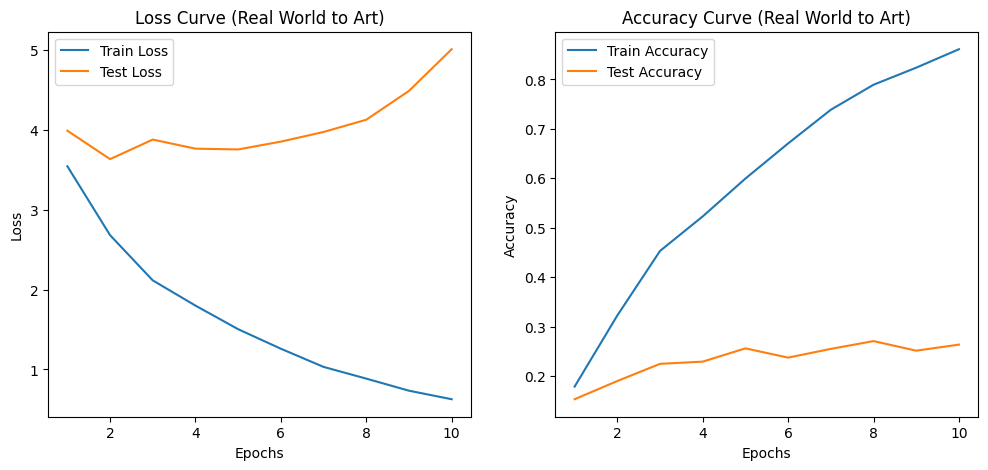

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Curve ({d_s} to {d_t})')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Accuracy Curve ({d_s} to {d_t})')
plt.legend()
plt.show()

# Visualisation

In [5]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model.load_state_dict(torch.load(f"resnet50_dann.pth"))

<All keys matched successfully>

In [6]:
features_map = []
labels = []

def get_feature():
    def hook(model, input, output):
        features_map.append(output.detach().cpu())
    return hook

# Register hook
model_hook = model.avgpool.register_forward_hook(get_feature())

model.to(device)
model.eval()

def extract_features(loader, max_samples=1000):
    features_map.clear()
    labels.clear()

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            _ = model(x)
            labels.extend(y.cpu().numpy())

            if len(labels) >= max_samples:
                break

    features = torch.cat(features_map, dim=0).view(len(labels), -1)[:max_samples]
    return features, labels[:max_samples]

# --- Extract features for train and test ---
train_features, train_labels = extract_features(train_loader, max_samples=1000)
test_features, test_labels = extract_features(test_loader, max_samples=1000)

# Remove hook after done
model_hook.remove()

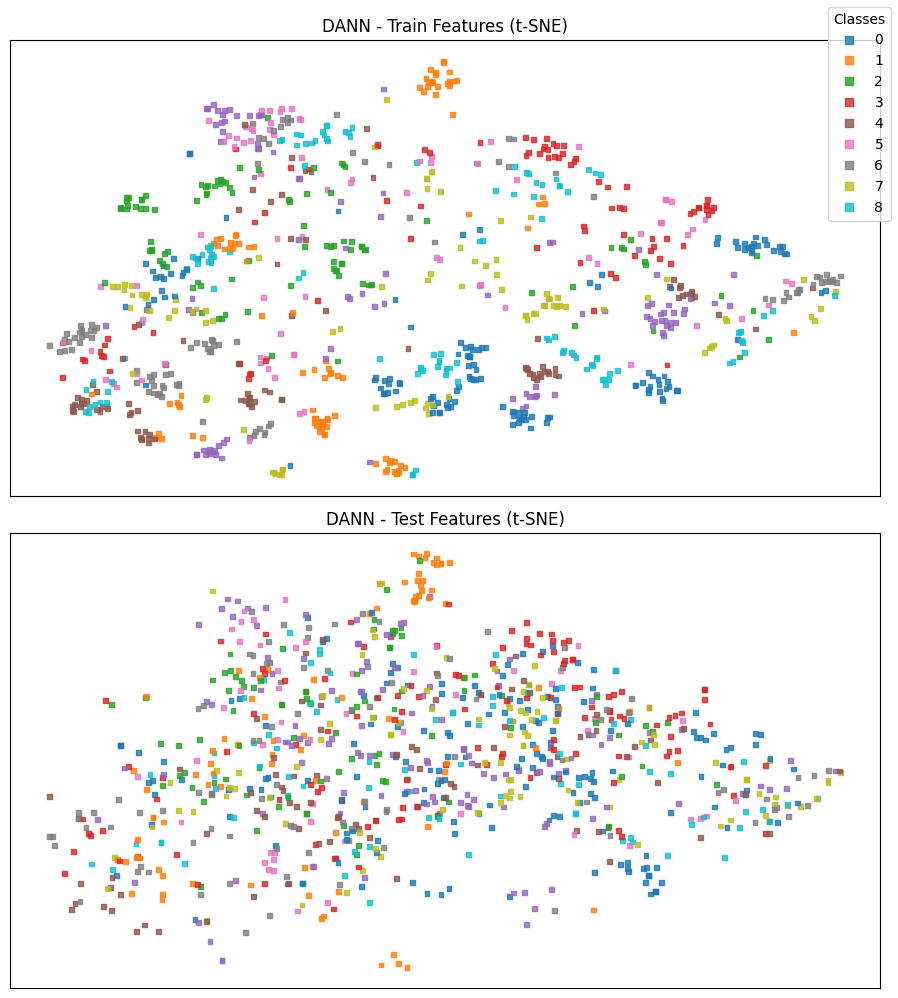

In [23]:
def plot_tsne(train_features, train_labels, test_features, test_labels, perplexity=30, random_state=42):
    # Convert tensors to numpy
    train_features = train_features.cpu().numpy() if hasattr(train_features, "cpu") else np.array(train_features)
    test_features = test_features.cpu().numpy() if hasattr(test_features, "cpu") else np.array(test_features)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)

    # Joint t-SNE for consistent space
    combined_features = np.concatenate([train_features, test_features], axis=0)
    combined_2d = TSNE(n_components=2, perplexity=perplexity, random_state=random_state).fit_transform(combined_features)

    n_train = len(train_features)
    train_2d, test_2d = combined_2d[:n_train], combined_2d[n_train:]

    # --- Plot side-by-side ---
    fig, axes = plt.subplots(2, 1, figsize=(9, 10))

    scatter_train = axes[0].scatter(train_2d[:, 0], train_2d[:, 1],
                                    c=train_labels, cmap="tab10", s=12, marker='s', alpha=0.8)
    axes[0].set_title("DANN - Train Features (t-SNE)")
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    scatter_test = axes[1].scatter(test_2d[:, 0], test_2d[:, 1],
                                   c=test_labels, cmap="tab10", s=12, marker='s', alpha=0.8)
    axes[1].set_title("DANN - Test Features (t-SNE)")
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    # Shared legend for class colors
    handles, _ = scatter_train.legend_elements(prop="colors")
    fig.legend(handles, np.unique(train_labels), title="Classes", loc="upper right")

    plt.tight_layout()
    plt.show()

plot_tsne(train_features, train_labels, test_features, test_labels)

In [22]:
def per_class_accuracy(model, loader, device, class_names=None):
    model.eval()
    model.to(device)

    correct_per_class = defaultdict(int)
    total_per_class = defaultdict(int)

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            logits = outputs
            preds = torch.argmax(logits, dim=1)

            for label, pred in zip(labels, preds):
                total_per_class[label.item()] += 1
                if pred.item() == label.item():
                    correct_per_class[label.item()] += 1
        # Compute accuracy per class
    accuracies = {}
    for label in range(len(total_per_class)):
        total = total_per_class[label]
        correct = correct_per_class[label]
        acc = 100.0 * correct / total if total > 0 else 0.0
        name = class_names[label] if class_names is not None else str(label)
        accuracies[name] = acc

    return accuracies

class_names = train_loader.dataset.classes
print("Source: ", per_class_accuracy(model, train_loader, device, range(65)))
class_names = test_loader.dataset.classes
print("Target", per_class_accuracy(model, test_loader, device, range(65)))

Target:  {0: 98.83720930232558, 1: 92.92929292929293, 2: 35.9375, 3: 39.75903614457831, 4: 97.97979797979798, 5: 98.71794871794872, 6: 86.25, 7: 64.38356164383562, 8: 100.0, 9: 100.0, 10: 98.95833333333333, 11: 86.15384615384616, 12: 79.6875, 13: 98.6842105263158, 14: 94.52054794520548, 15: 93.54838709677419, 16: 66.66666666666667, 17: 100.0, 18: 96.29629629629629, 19: 85.0, 20: 87.93103448275862, 21: 60.0, 22: 96.0, 23: 89.47368421052632, 24: 61.111111111111114, 25: 98.33333333333333, 26: 94.23076923076923, 27: 98.33333333333333, 28: 100.0, 29: 98.66666666666667, 30: 95.18072289156626, 31: 94.87179487179488, 32: 97.01492537313433, 33: 17.391304347826086, 34: 35.2112676056338, 35: 82.6086956521739, 36: 98.33333333333333, 37: 65.51724137931035, 38: 88.23529411764706, 39: 76.5625, 40: 70.0, 41: 60.294117647058826, 42: 84.61538461538461, 43: 79.66101694915254, 44: 95.5223880597015, 45: 98.07692307692308, 46: 94.33962264150944, 47: 54.54545454545455, 48: 81.33333333333333, 49: 97.560975609